<a href="https://colab.research.google.com/github/dcheney01/DeepLearning/blob/main/CNN_initialization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this project was to implement the following Pytorch functions:
* CrossEntropyLoss
* Conv2d


And create a convolution network that can use uniform, orthogonal, and xavier weight initializations. There is also a function to calculate the number of parameters in the model at the end.

In [ ]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [ ]:
# Dataset class to manage the FashionMNIST dataset
class FashionMNISTProcessedDataset(Dataset):
  def __init__(self, root, train = True):
    self.data = datasets.FashionMNIST(root, 
                                      train=train,
                                      transform=transforms.ToTensor(),
                                      download=True)
    
  def __getitem__(self, i):
    x, y = self.data[i]
    return x, y

  def __len__(self):
    return len(self.data)

In [ ]:
class CrossEntropyLoss(nn.Module):
  def __init__(self, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean'):
    self.__dict__.update(locals())
    super(CrossEntropyLoss, self).__init__()

  def forward(self, x, xClass):
    # softmax function
    return torch.mean(-x[torch.arange(xClass.shape[0]), xClass] + torch.logsumexp(x,1))

In [ ]:
# Implement Conv2d class that can be initialized with uniform, orthogonal, or xavier weight distribution
class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, initialization="uniform"):
      self.__dict__.update(locals())
      super(Conv2d, self).__init__()

      self.weight = Parameter(torch.zeros(out_channels,
                                          in_channels,
                                          *kernel_size))
      self.bias = Parameter(torch.zeros(out_channels))

      if initialization == "uniform":  
        self.weight.data.uniform_(-1,1)

      elif initialization == "orthogonal":
        X = np.random.random((out_channels, in_channels * kernel_size[0] * kernel_size[1]))
        trash1, trash2, Vt = np.linalg.svd(X, full_matrices=False)
        self.weight.data = torch.from_numpy(Vt.reshape(out_channels, in_channels, kernel_size[0], kernel_size[1])).float()

      elif initialization == "xavier":
        n_out = out_channels * kernel_size[0] * kernel_size[1]
        n_in = in_channels * kernel_size[0] * kernel_size[1]
        var_w = 2 / (n_in+n_out)
        self.weight.data = torch.from_numpy(np.random.normal(scale=np.sqrt(var_w), size=self.weight.data.shape)).float()
        # we want a random distribution with small(depending on weight matrix) weights

  
    def forward(self, x):
      return F.conv2d(x, self.weight, self.bias, self.stride, 
                      self.padding, self.dilation, self.groups)

In [ ]:
class ConvNetwork(nn.Module):
    def __init__(self, dataset, initialization="uniform"):
      super(ConvNetwork, self).__init__()
      x, y = dataset[0]
      c, h, w = x.size()
      output = 10

      self.net = nn.Sequential(
          Conv2d(c, 8, (3, 3), padding=(1,1), initialization=initialization),
          nn.ReLU(),
          Conv2d(8, 64, (3, 3), padding=(1,1), initialization=initialization),
          nn.ReLU(),
          Conv2d(64, 128, (3, 3), padding=(1,1), initialization=initialization),
          nn.ReLU(),
          Conv2d(128, output, (28, 28), padding=(0,0), initialization=initialization))
    def forward(self, x):
      return self.net(x).squeeze(2).squeeze(2)

In [ ]:
# Initialize Datasets
train_dataset = FashionMNISTProcessedDataset('/tmp/fashionMNIST', train=True)
val_dataset = FashionMNISTProcessedDataset('/tmp/fashionMNIST', train=False)

# Initialize DataLoaders
train_loader = DataLoader(train_dataset, 
                          batch_size=42, 
                          pin_memory=True)
val_loader = DataLoader(val_dataset,
                        batch_size=42,
                        pin_memory=True)


# Initialize Model
initialization = "uniform"
model = ConvNetwork(train_dataset, initialization=initialization)
model = model.cuda()

# Initialize Objective and Optimizer and other parameters
optimizer = optim.Adam(model.parameters(), lr=1e-4)
objective = CrossEntropyLoss()

epochs = 5
validation_frequency = 100

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /tmp/fashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /tmp/fashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /tmp/fashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /tmp/fashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /tmp/fashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/fashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /tmp/fashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/fashionMNIST/FashionMNIST/raw



In [ ]:
# Make sure all lists are cleared
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Run training and validation loop and collect stats
for epoch in range(epochs):
  train_loss_list = []
  train_accuracy_list = []

  loop = tqdm(total=len(train_loader), position=0, leave=False)

  for batch, (x, y_truth) in enumerate(train_loader):
    x, y_truth = x.cuda(non_blocking=True), y_truth.cuda(non_blocking=True)

    optimizer.zero_grad()
    y_hat = model(x)

    train_loss = objective(y_hat, y_truth)
    train_loss.backward()
    train_loss_list.append(train_loss.item())

    train_accuracy = ((y_hat).argmax(1) == y_truth).float().mean()
    train_accuracy_list.append(train_accuracy.item())

    loop.set_description('epoch:{}  loss:{:.4f} accuracy:{:.3f}'.format(epoch, train_loss.item(), train_accuracy))
    loop.update(1)

    optimizer.step()

    if (batch+1) % validation_frequency == 0:
      train_losses.append(np.mean(train_loss_list))
      train_accuracies.append(np.mean(train_accuracy_list))  

      val_loss_list = []
      val_accuracy_list = []
      val_accuracy = None

      for a, b in val_loader:
        val_y_hat, val_y_truth = model(a.cuda()), b.cuda()
        val_loss = objective(val_y_hat, val_y_truth).item()
        val_loss_list.append(val_loss)

        val_accuracy = ((val_y_hat).argmax(1) == val_y_truth).float().mean()
        val_accuracy_list.append(val_accuracy.item())
        
      val_accuracies.append(np.mean(val_accuracy_list))
      val_losses.append(np.mean(val_loss_list))

  loop.close()

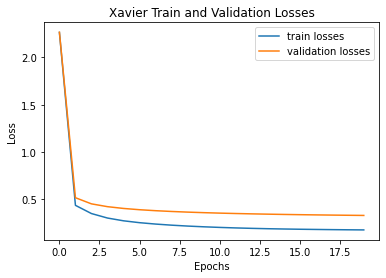

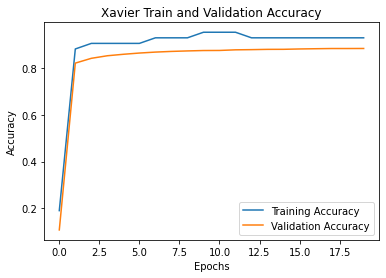

In [ ]:
# XAVIER INITIALIZATION
# Plot loss if you want
plt.plot(train_losses, label='train losses')
plt.plot(val_losses, label='validation losses')
plt.title("Xavier Train and Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot accuracy
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Xavier Train and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

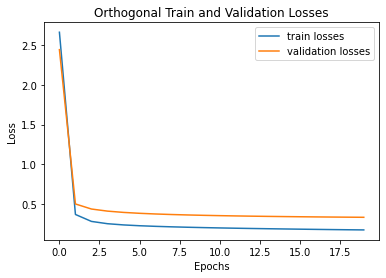

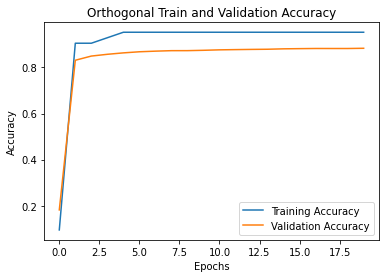

In [ ]:
# ORTHOGONAL INITIALIZATION
# Plot loss if you want
plt.plot(train_losses, label='train losses')
plt.plot(val_losses, label='validation losses')
plt.title("Orthogonal Train and Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot accuracy
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Orthogonal Train and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

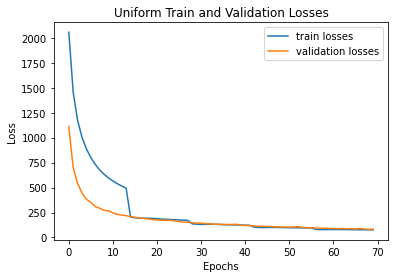

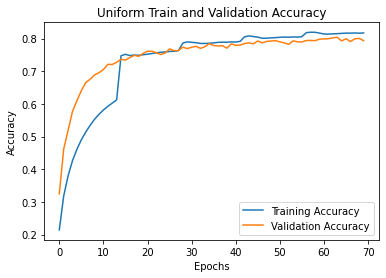

In [ ]:
# UNIFORM INITIALIZATION
# Plot loss if you want
plt.plot(train_losses, label='train losses')
plt.plot(val_losses, label='validation losses')
plt.title("Uniform Train and Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot accuracy
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Uniform Train and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# Compute and print the number of parameters in the model
total = 0
for p in model.parameters():
  total += np.prod(p.size())

print(total)

1082138
